In [1]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Machine Learning libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL


from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (12, 5), 'figure.dpi': 120})


from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

C:\Users\enriq\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


torch installation could not be found, only numpy activation functions allowed


---
## 1. Read the dataset

Indicamos que la variable date tiene fechas (parse_dates), para decirle que no es una variable mas sino que es un indice de fechas. 

Al leer el df, no lo configuramos como una variable más sino como un indice. 

In [2]:
# Import data
dateparse = lambda x :datetime.strptime(x ,"%d/%m/%Y")

df = pd.read_csv('UnemploymentSpain.dat',sep='\t', parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


In [3]:
df.shape

(262, 1)

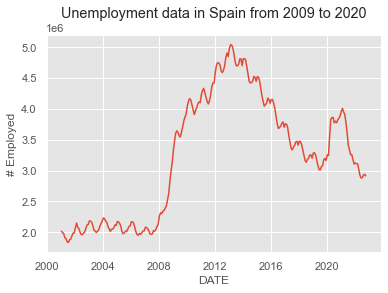

In [4]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2020', xlabel='DATE', ylabel='# Employed')
plt.show()

Vemos que no hay **constancia ni en la media ni en la varianza**, por lo que deberemos estabilizarlas.

Viendo esta serie, aun no puedo saber si es autorregresiva, ruido blanco o lo que sea.

In [5]:
df_unemployment = df[['TOTAL']] # Maintain data.frame format for column
df_unemployment

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


<Figure size 432x288 with 0 Axes>

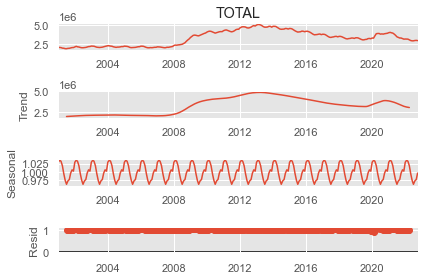

In [6]:
# Multplicative Decomposition
result_mul = seasonal_decompose(df_unemployment['TOTAL'], model='multiplicative')
plt.figure()
result_mul.plot()
plt.show()

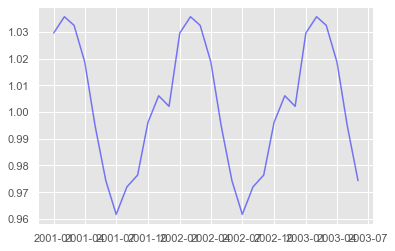

In [7]:
plt.plot(result_mul.seasonal[:30], color='blue', alpha=0.5, label='Multiplicative seasonal')


Una vez estabilizada la varianza, tengo que analizar la parte estacionaria. Si nos fijamos, vemos que claramente tenemos que diferenciar la media.
A continuacion, pintamos de nuevo la distribucion de la varianza. Vemos que ahora es una linea horizontal y que, además, el valor de lambda es muy cercano a 1. Esto nos indica que se ha estabilizado correctamente.


In [8]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.161 #Select lambda
    z = st.boxcox(df_unemployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_unemployment.columns.values.tolist())
else:
    z = df_unemployment

In [9]:
# Alternative test - Augmented Dickey Fuller Test
# Aplicando este test, podemos saber si debemos realizar diferenciacion para la media o no. Si el pvalor es mayor de 0.05, se realiza diferenciacion
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [10]:
linear_covid = np.arange(0,1,1/len(df_unemployment.loc["2020-03-01":]))
linear_covid = linear_covid[::-1]
linear_covid

array([0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 , 0.78125,
       0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375, 0.5625 ,
       0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  , 0.34375,
       0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625, 0.125  ,
       0.09375, 0.0625 , 0.03125, 0.     ])

In [11]:
uniform_covid = np.random.uniform(0, 1,size=len(df_unemployment.loc["2020-03-01":]))
uniform_covid = np.sort(uniform_covid) 
uniform_covid = uniform_covid[::-1]
# plt.plot(uniform_covid)

Vamos a añadir una columna nueva a nuestro dataframe, indicando con un 0 la epoca en la que no había covid y con un 1 en la que sí.
Además, en el rango de fechas en el que si hay covid, vamos a generar una rampa (Decay), para darle más o menos peso al covid en 
funcion de si estamos más o menos cerca de la cuarentena (Que, como hemos visto, provocó el pico maximo de paro de esas fechas)

En concreto, vamos a generar dos columnas, una para un linear decay, en el que estaremos indciandole al modelo que el covid decrece linealmente y un exponential decay, en el que estaremos indicandole un decrecimiento exponencial de la importancia del covid, y compararemos ambos, para ver cuál se ajusta mejor


In [12]:
df_unemployment["COVID_L"] = 0

df_unemployment.loc["2020-03-01":, "COVID_L"] = linear_covid
df_unemployment

,TOTAL,COVID_L
DATE,,
2001-01-01,2017389,0.00000
2001-02-01,1993273,0.00000
2001-03-01,1981006,0.00000
2001-04-01,1910453,0.00000
2001-05-01,1898285,0.00000
...,...,...
2022-06-01,2880582,0.12500
2022-07-01,2883812,0.09375
2022-08-01,2924240,0.06250


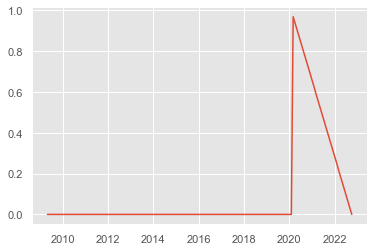

In [13]:
plt.plot(df_unemployment[100:]["COVID_L"])
plt.show()

In [14]:
df_unemployment['COVID_U'] = 0

df_unemployment.loc["2020-03-01":, "COVID_U"] = uniform_covid
df_unemployment

,TOTAL,COVID_L,COVID_U
DATE,,,
2001-01-01,2017389,0.00000,0.000000
2001-02-01,1993273,0.00000,0.000000
2001-03-01,1981006,0.00000,0.000000
2001-04-01,1910453,0.00000,0.000000
2001-05-01,1898285,0.00000,0.000000
...,...,...,...
2022-06-01,2880582,0.12500,0.049202
2022-07-01,2883812,0.09375,0.045802
2022-08-01,2924240,0.06250,0.025397


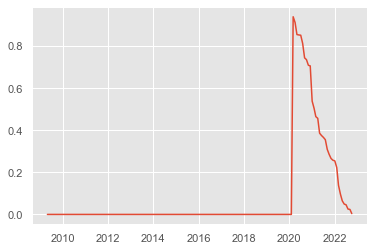

In [15]:
plt.plot(df_unemployment[100:]["COVID_U"])
plt.show()

In [16]:
df_unemployment_save = df_unemployment.copy()

In [17]:
df_unemployment = df_unemployment_save.copy()

In [18]:
# Define input and output matrices
INPUTS = ['COVID_L', 'COVID_U']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_unemployment[INPUTS]
y = df_unemployment[OUTPUT]


In [19]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = y, 
                            trend = 'c',
                            order=(1,1,3), # Regular components (p,d,q)
                            seasonal_order=(1, 1, 1, 12),  # Seasonal components [P,D,Q,S] 
                            #  ORDEN DE SARIMA (anterior)
                            # order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                            # seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                            exog = X,
                            enforce_invertibility=False, 
                            enforce_stationarity=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
res_sarimax.summary()

C:\Users\enriq\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\enriq\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -2826.223
Date:                              Thu, 16 Feb 2023   AIC                           5672.447
Time:                                      20:30:14   BIC                           5706.957
Sample:                                  01-01-2001   HQIC                          5686.363
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -351.5873   1656.786     -0.212      0.832   -3598.828    2895.653
COVID_L     5.164e+05   1.75e+05      2.957      0.003    1.74e+05    8.59e+05
COVID_U    -1.755e+05   1.79e+05     -0.979      0.328   -5.27e+05    1.76e+05
ar.L1          0.8564      0.114      7.514      0.000       0.633       1.080
ma.L1         -0.3930      0.136     -2.887      0.004      -0.660      -0.126
ma.L2         -0.0182      0.118     -0.155      0.877      -0.249       0.212
ma.L3         -0.1231      0.069     -1.788      0.074      -0.258       0.012
ar.S.L12      -0.2327      0.059     -3.952      0.000      -0.348      -0.117
ma.S.L12      -0.1544      0.044     -3.475      0.001      -0.241      -0.067
sigma2      2.332e+09     71.899   3.24e+07      0.000    2.33e+09    2.33e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5642.20
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.57   Skew:                             2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+23. Standard errors may be unstable.
"""

C:\Users\enriq\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


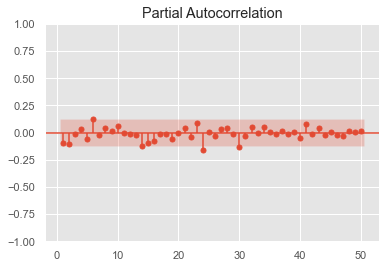

<Figure size 432x288 with 0 Axes>

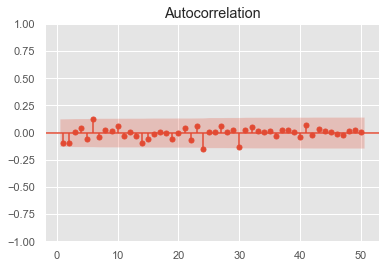

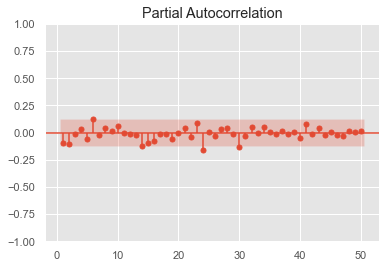

In [20]:
#Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plot_acf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)
plot_pacf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)

2021-11-01    3.226738e+06
2021-12-01    3.122732e+06
2022-01-01    3.103449e+06
2022-02-01    3.106745e+06
2022-03-01    3.038839e+06
2022-04-01    3.181490e+06
2022-05-01    2.869412e+06
2022-06-01    2.776311e+06
2022-07-01    2.758337e+06
2022-08-01    2.920456e+06
2022-09-01    2.910877e+06
2022-10-01    3.004387e+06
2022-11-01    2.883638e+06
2022-12-01    2.851761e+06
Freq: MS, Name: predicted_mean, dtype: float64


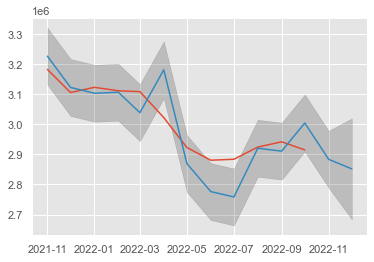

In [21]:
#Obtain forecasts for in-sample and out-of-sample
start = 250
horizon = 1
end = df_unemployment.shape[0] + horizon

pred = res_sarimax.get_prediction(start=start, 
                                    end= end, 
                                    exog = df_unemployment[INPUTS][0:2],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)
print(yhat)
pred_sarimax = yhat
initial_date = df_unemployment.index[start]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [22]:
df_predicciones = pd.DataFrame()

In [23]:
df_predicciones['pred_sarimaX'] = pred_sarimax[:-1]
df_predicciones['original'] = df[['TOTAL']][250:]

In [24]:
df_predicciones

,pred_sarimaX,original
2021-11-01,3.226738e+06,3182687.0
2021-12-01,3.122732e+06,3105905.0
2022-01-01,3.103449e+06,3123078.0
2022-02-01,3.106745e+06,3111684.0
2022-03-01,3.038839e+06,3108763.0
2022-04-01,3.181490e+06,3022503.0
2022-05-01,2.869412e+06,2922911.0
2022-06-01,2.776311e+06,2880582.0
2022-07-01,2.758337e+06,2883812.0
2022-08-01,2.920456e+06,2924240.0


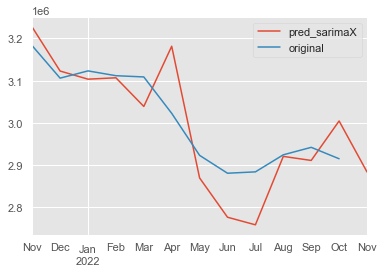

In [25]:
df_predicciones.plot()
plt.show()

In [26]:
# Ahora podemos obtener el numero de personas que predice nuestro modelo 
num_parados_noviembre = yhat.loc["2022-11-01"]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {int(num_parados_noviembre)} personas")

El numero de parados en octubre fue de 2914892.0 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2883638 personas


El paro **REAL** del mes de Noviembre fue de **2.881.380** por lo que hemos fallado por 2258 personas,... **BASTANTE BIEN!**